In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


## 1.1.0 Load and clean up data

In [3]:
raw_data_df = pd.read_csv('../spotify_dataset/data.csv')
raw_data_df['artists'] = raw_data_df['artists'].apply(lambda x: x[1:-1].replace("'",'').split(','))

#Lets find tracks where multiple artists contributed and make a new row for each individual artist
raw_data_df = raw_data_df.explode('artists')
raw_data_df['artists'] = raw_data_df['artists'].str.strip()
raw_data_df['release_date'] = pd.to_datetime(raw_data_df['release_date'])
total_na_values = raw_data_df.isna().sum().sum()
print("{} Total Nan in df".format(total_na_values))

0 Total Nan in df



## 1.2.0 Better with age?
#### Let's look at a few prominent artists and see how they grow in popularity through their career



Artist: Michael Jackson,  Adjusted Popularity/Year = 0.778
Artist: Bob Dylan,  Adjusted Popularity/Year = 0.322
Artist: The Beatles,  Adjusted Popularity/Year = 0.127
Artist: Fleetwood Mac,  Adjusted Popularity/Year = 0.541
Artist: Johnny Cash,  Adjusted Popularity/Year = 1.305
Artist: Kendrick Lamar,  Adjusted Popularity/Year = 0.372


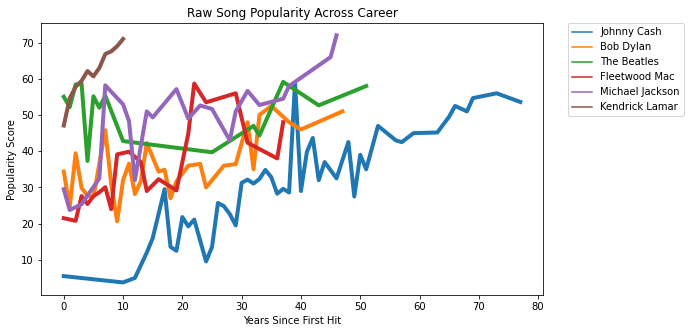

In [6]:

some_good_artists = ['Michael Jackson',
                    'Bob Dylan',
                    'The Beatles',
                    'Fleetwood Mac',
                    'Johnny Cash',
                    'Kendrick Lamar']

good_tunes = raw_data_df[raw_data_df['artists'].isin(some_good_artists)].copy()
good_tunes['year_from_max'] = good_tunes.year - good_tunes.groupby(['artists'])['year'].transform(min)


fig,ax = plt.gcf(),plt.gca()
sns.lineplot(x='year_from_max',y='popularity',data=good_tunes,hue='artists',ci=None,linewidth=4)

fig.set_size_inches(9,5)
ax.set_title("Raw Song Popularity Across Career")
ax.set_xlabel('Years Since First Hit')
ax.set_ylabel('Popularity Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#Print Groth Rate for each artist
for artist in some_good_artists:
    X = good_tunes[good_tunes['artists']==artist]['popularity'].values
    Y = good_tunes[good_tunes['artists']==artist]['year_from_max'].values 
    #Adjusting Y because year may influence popularity metric //\\ can check np.corcoef(popularity,year)
    Y_adjusted = Y + good_tunes[good_tunes['artists']==artist]['year'].values 
    year_adjusted_slope = ((X*Y_adjusted).mean() - X.mean()*Y_adjusted.mean()) / ((X**2).mean() - (X.mean())**2)
    print("Artist: {},  Adjusted Popularity/Year = {}".format(artist,round(year_adjusted_slope,3)))

## 1.2.1 Pretty impressive growth from Michael Jackson! Let's take a deeper look into his music and see if we find features that correlate with this popularity growth

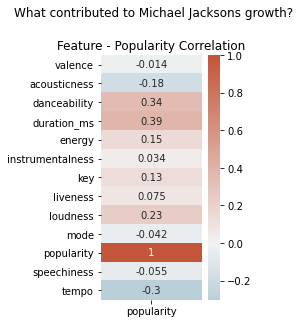

In [8]:
michael_jackson = good_tunes[good_tunes['artists']=='Michael Jackson']
drop_cols = ['name','release_date','year','year_from_max','artists','id','explicit']
michael_jackson = michael_jackson.drop(drop_cols,axis=1)
corr_values = michael_jackson.corr()['popularity'].to_frame()

fig,axe = plt.gcf(),plt.gca()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_values, annot=True, center=0, cmap = cmap)
plt.suptitle('What contributed to Michael Jacksons growth?',y=1.03,x=0.45)
axe.set_title('Feature - Popularity Correlation')
fig.set_size_inches(2.25,4.5)

## 2.0 Can we predict which decade a song is from just from features? 


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, confusion_matrix


## 2.1 Use K-nearest neighbors with Kfold to examine decade classification

224628 Datapoints with 10 unique clusters



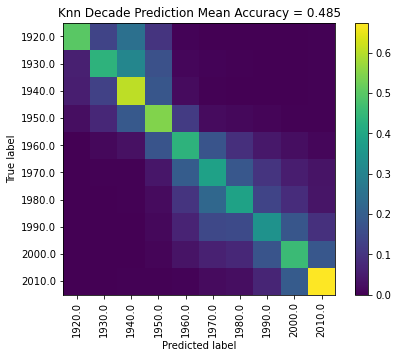

In [10]:
#Create decade column
raw_data_df['decade'] = raw_data_df['year'].apply(lambda x:int(x//10*10))

#Remove unimportant/covariate columns and normalize features
non_feature_cols = ['id','name','release_date','year','artists','mode']
decade_df = raw_data_df.drop(non_feature_cols,axis=1)
decade_fts = [col for col in decade_df if 'decade'!=col]
decade_df[decade_fts] = decade_df[decade_fts].apply(lambda x:(x - x.min()) / (x.max() - x.min()) )

#Remove 2020 because not a full decade of data!
decade_df = decade_df[decade_df.decade < 2020]

decade_group_size_thresh = 1000
decade_df = decade_df.groupby('decade').filter(lambda x: len(x)> decade_group_size_thresh)
print("{} Datapoints with {} unique clusters\n".format(len(decade_df),len(decade_df.decade.unique())))

#Use k-fold to examine performance of 10 NearestNeighbor models
features_array = decade_df.values
num_clusts = len(decade_df.decade.unique())
kf = KFold(n_splits=10,shuffle=True)
accuracies = []
for train_index,test_index in kf.split(features_array):
    train_labels = features_array[train_index,-1]
    train_data = features_array[train_index,0:-2]
    test_labels = features_array[test_index,-1]
    test_data = features_array[test_index,0:-2]
    knn = KNeighborsClassifier(n_neighbors = num_clusts)
    knn.fit(train_data,train_labels)
    accuracy = knn.score(test_data,test_labels)
    accuracies.append(accuracy)
mean_accuracy = round(np.mean(accuracies),3)

fig,ax = plt.gcf(),plt.gca()
plot_confusion_matrix(knn,test_data,test_labels,
                      normalize='true',
                      xticks_rotation = 'vertical',
                      include_values = False,
                      ax=ax)
fig.set_size_inches(7,5)
ax.set_title("Knn Decade Prediction Mean Accuracy = {}".format(mean_accuracy))
plt.show()

 ## 2.1 Random Forest Classification
 
 ##### Results from Knn are not that exciting, perhaps this is due to the high number of samples, and high dimensionality. Let's use a random forest classifier engine and examine results


-----------------------------------------------------------------
RFC Predicting: decade
-----------------------------------------------------------------

There are 10 unique labels in the 224628 datapoints 

Average performance = 69.22% prediction accuracy

Top Five Features Based on Gini Index:
10.2 popularity
5.3 acousticness
4.6 loudness
4.12 duration_ms
3.97 energy
3.72 speechiness


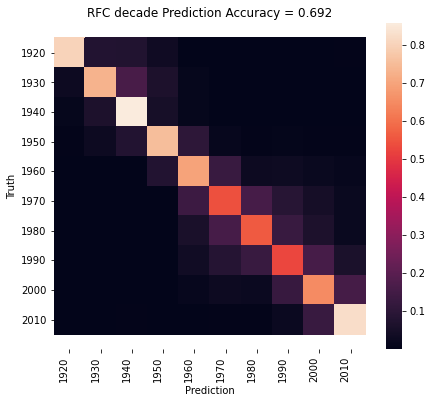

In [13]:
rfc_fig,rfc_ax = random_forest_classifier_engine(decade_df,decade_fts,'decade')

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def random_forest_classifier_engine(df,ft_cols, labels_col):
    feature_values = df[ft_cols].values
    labels = df[labels_col].values

    print('-----------------------------------------------------------------')
    print('RFC Predicting: {}'.format(labels_col))
    print('-----------------------------------------------------------------'+'\n')
    print('There are {} unique labels in the {} datapoints \n'.format(len(df[labels_col].unique()),len(labels)))

    score = np.zeros(len(ft_cols))
    avg_score = []
    possible_labels = df[labels_col].unique()
    num_correct = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    num_occurances = dict(zip(possible_labels,np.zeros(len(possible_labels))))
    value_counts_dict = dict(zip(df[labels_col].unique(),df[labels_col].value_counts()))
    conf_mat = np.zeros([len(np.unique(labels)),len(np.unique(labels))])

    #Run RFC over 50 iterations and 
    for it in range(0,50):
        X_train, X_test, Y_train, Y_test = train_test_split(feature_values, labels, test_size=0.10)
        clf = RandomForestClassifier(random_state=0,n_estimators=100,min_samples_leaf=3,
                                     min_samples_split=3,oob_score=True,max_depth = None, class_weight='balanced' )
        clf.fit(X_train, Y_train)
        results = clf.predict(X_test)
        # getting per class accuracy scores
        for ind,res in enumerate(results):
            num_occurances[Y_test[ind]]+=1
            if res == Y_test[ind]:
                num_correct[res]+=1          
        conf_mat+=confusion_matrix(Y_test,results,labels = possible_labels)
        mean_score = clf.score(X_test,Y_test)
        avg_score.append(mean_score)
        score+=clf.feature_importances_
    average_performance = np.mean(np.asarray(avg_score))
    print('Average performance = {}% prediction accuracy\n'.format(round(100*average_performance,2)))
    score_dict = dict(zip(score,ft_cols))
    top_ten_scores = []
    print('Top Five Features Based on Gini Index:')
    for enum,i in enumerate(sorted(score_dict,reverse=True)):
        print(round(i,2),score_dict[i])
        top_ten_scores.append(score_dict[i])
        if enum == 5:
            break

    #confusion matrix
    ax = plt.gca()
    fig = plt.gcf()
    row_sums = np.sum(conf_mat,axis=1)
    percent_conf_mat = (conf_mat.T / row_sums).T
    np.nan_to_num(percent_conf_mat,0)
    labels_sorted = sorted(possible_labels)

    con = sns.heatmap(percent_conf_mat,annot=False, xticklabels=labels_sorted,yticklabels= labels_sorted)

    ax.set_ylim(len(percent_conf_mat)+0.5, -0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right')
    ax.set_yticklabels(ax.get_xticklabels(), rotation=0,horizontalalignment='right')
    con.set_xlabel('Prediction')
    con.set_ylabel('Truth')
    fig.set_size_inches(7,6)
    ax.set_title(f'RFC {labels_col} Prediction Accuracy = {round(average_performance,3)}')
    return fig,ax

# 3.0.0 Unsupervised clustering 
#### Can we create unsupervised clusters based on features provided? Using both ward heirarchical clustering and kmeans, we can define clusters and visualize some clustering results

In [21]:
cols_to_drop = ['id','name','release_date','year','mode']

feature_df = raw_data_df.drop(cols_to_drop,axis=1)
feature_columns = [c for c in feature_df.columns if c != 'artists']
feature_df = feature_df[['artists']+feature_columns]
feature_df[feature_columns]=(feature_df[feature_columns]-feature_df[feature_columns].min())/(feature_df[feature_columns].max()-feature_df[feature_columns].min())
feature_df_sample = feature_df.sample(30000)
feature_matrix = feature_df_sample.values
data = feature_matrix[:,1:]

## 3.1.0 Determine Number of Clusters in Data

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score

#Calculate silhouette and sse error for num_clusters in range 2-100
"""
silhouette value calculated is the percentage of clusters where the mean silhouette score is 
greater than that of all datapoints. Justification for this is that it is a quantitative 
approach and doesn't require as many plots as traditional horizontal silhouette histograms (See link)
https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_silhouette_analysis_005.png

Want to ensure that the chosen number of clusters is at a relative peak 
"""

num_clust_range = range(5,100)  
inertia_vals = [] 
percent_of_quality_clusters = []
for k in num_clust_range:
    clusterer = KMeans(n_clusters = k)
    cluster_labels = clusterer.fit_predict(data)
    inertia_vals.append(clusterer.inertia_)
    
    average_silhouette_score = silhouette_score(data,cluster_labels,metric='euclidean')
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    high_quality_cluster_ct = 0
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        clusters_mean_sil_score = ith_cluster_silhouette_values.mean()
        if clusters_mean_sil_score > average_silhouette_score:
            high_quality_cluster_ct+=1

    percent_of_clusters_above_average = high_quality_cluster_ct/k
    percent_of_quality_clusters.append(percent_of_clusters_above_average)

## 3.1.1 Plot chosen number of clusters

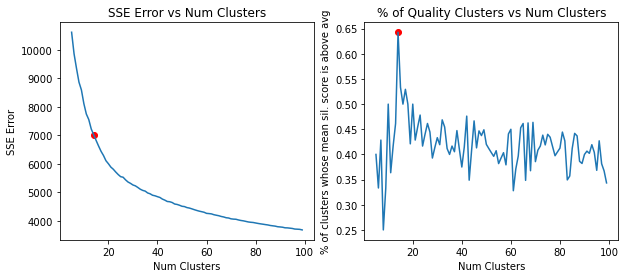

In [25]:
chosen_n_clust = 14
chosen_n_clust_ind = chosen_n_clust-min(num_clust_range)
f,axe = plt.subplots(1,2)
axe[0].plot(num_clust_range,inertia_vals)
axe[0].set_title('SSE Error vs Num Clusters')
axe[0].scatter(chosen_n_clust, inertia_vals[chosen_n_clust_ind],c='r',marker='o')
axe[0].set_xlabel('Num Clusters')
axe[0].set_ylabel('SSE Error')

axe[1].plot(num_clust_range,percent_of_quality_clusters)
axe[1].set_title('% of Quality Clusters vs Num Clusters')
axe[1].scatter(chosen_n_clust,percent_of_quality_clusters[chosen_n_clust_ind],marker='o',c='r')
axe[1].set_xlabel('Num Clusters')
axe[1].set_ylabel('% of clusters whose mean sil. score is above avg')
f.set_size_inches(10,4)


## 3.2.0 Run ward heirarchical clustering with optimal num clusters
#### The reuslting dataframe shows the clusterid's with the 2 most popular artists (by occurance) from a given cluster
#### Expecting to see similar sounding artists within clusters

In [32]:
km = KMeans(n_clusters=chosen_n_clust)
km.fit(data)
predictions = km.labels_

#Put results into dataframe
cluster_results = pd.DataFrame({'cluster_id':predictions,'artists':feature_matrix[:,0]})
unique_clust_id = cluster_results.cluster_id.unique()
cluster_results['within_cluster_count'] = cluster_results.groupby(['cluster_id','artists']).artists.transform('size')

#Keep n most popular artists from each cluster
top_artists,ids = [],[]
n_arts = 2
for clustid in unique_clust_id:
    this_clust = cluster_results[cluster_results.cluster_id == clustid]
    top_n_artists = this_clust.sort_values(by='within_cluster_count',ascending=False).artists.unique()[0:n_arts]
    [ids.append(f) for f in [clustid]*n_arts]
    [top_artists.append(a) for a in top_n_artists]
results_df = pd.DataFrame({'clusterid':ids,'artists':top_artists})
results_df[['clusterid','artists']]


,clusterid,artists
0,6,Taylor Swift
1,6,Queen
2,0,Ludwig van Beethoven
3,0,Frédéric Chopin
4,11,Giuseppe Verdi
5,11,Frank Sinatra
6,9,Francisco Canaro
7,9,Billie Holiday
8,3,Bob Marley & The Wailers
9,3,The Beach Boys



## 3.3.0 Run KMean clustering and plot cluster centers (with artist labels)
#### Use PCA to reduce cluster centers to 2-d for cluster visualization

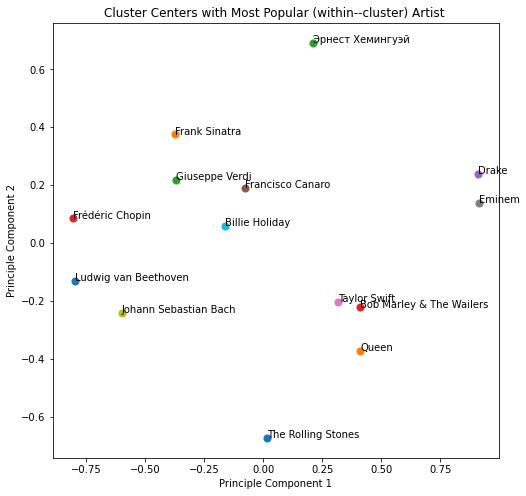

In [73]:
import sklearn.decomposition as decomposition
from sklearn.cluster import KMeans

def pca_components(X,exp_var=0.05):
    pca = decomposition.PCA()
    pca.fit(X)
    keeping_pcs = pca.explained_variance_ratio_ > exp_var
    return pca.transform(X)[:,keeping_pcs]

clust_centers = km.cluster_centers_
centers_2d = pca_components(clust_centers)[:,0:2]
rand_noise = np.random.uniform(low=-0.15, high=0.15, size=(len(centers_2d))) 
#add in some random noise in the y-dimension to seperation y text labels
centers_2d[:,1]+=rand_noise 

f,a = plt.gcf(),plt.gca()
unique_artists = set([])
for i,coord in enumerate(centers_2d):
    artist = results_df[results_df.clusterid == i].artists.values[0]
    if artist in unique_artists:
        artist = results_df[results_df.clusterid == i].artists.values[1]
    unique_artists.add(artist)
    a.annotate(artist,(coord[0],coord[1]))
    a.scatter(coord[0],coord[1],s=50)

texts = a.texts
# adjust_text(texts,autoalign=True) #no great solution for overlapping text here 
a.set_title("Cluster Centers with Most Popular (within--cluster) Artist ")
a.set_ylabel("Principle Component 2")
a.set_xlabel("Principle Component 1")
f.set_size_inches(8,8)


